# Anomaly Detection

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from time import time
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Catfish Sales data

In [16]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [17]:
df = pd.read_csv("catfish.csv")
df

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239
...,...,...
319,2012-8-01,14442
320,2012-9-01,13422
321,2012-10-01,13795
322,2012-11-01,13352


In [18]:
#read Data

catfish_df = pd.read_csv("catfish.csv",parse_dates = [0], index_col = 0, squeeze = True,date_parser = parser)

catfish_df

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Name: Total, Length: 324, dtype: int64

In [19]:
#infer the frequency

catfish_df = catfish_df.asfreq(pd.infer_freq(catfish_df.index))

In [20]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)

catfish_sales = catfish_df[start_date:end_date]

In [21]:
catfish_sales

Date
1996-01-01    20322
1996-02-01    20613
1996-03-01    22704
1996-04-01    20276
1996-05-01    20669
1996-06-01    18074
1996-07-01    18719
1996-08-01    20217
1996-09-01    19642
1996-10-01    20842
1996-11-01    18204
1996-12-01    16898
1997-01-01    20746
1997-02-01    23058
1997-03-01    24624
1997-04-01    22154
1997-05-01    22444
1997-06-01    21471
1997-07-01    21866
1997-08-01    22548
1997-09-01    21518
1997-10-01    23408
1997-11-01    19645
1997-12-01    18278
1998-01-01    23576
1998-02-01    26650
1998-03-01    26207
1998-04-01    23195
1998-05-01    22960
1998-06-01    23002
1998-07-01    22973
1998-08-01    24089
1998-09-01    22805
1998-10-01    23241
1998-11-01    21581
1998-12-01    21119
1999-01-01    23107
1999-02-01    25780
1999-03-01    28544
1999-04-01    23488
1999-05-01    23964
1999-06-01    23720
1999-07-01    25069
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name:

In [22]:
catfish_sales[datetime(1998,12,1)]

21119

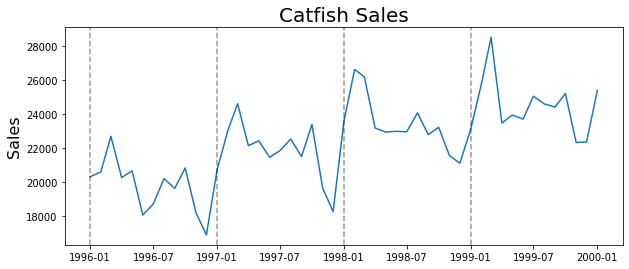

In [23]:
plt.figure(figsize = (10,4))
plt.plot(catfish_sales)

plt.title("Catfish Sales", fontsize = 20)
plt.ylabel("Sales", fontsize = 16)

for year in range(start_date.year, end_date.year):
    plt.axvline(datetime(year,1,1), color = "k", linestyle = "--", alpha = 0.4)

In [24]:
# create an anomaly by replaceing the real data from original dataset

catfish_sales[datetime(1998,12,1)] = 10000

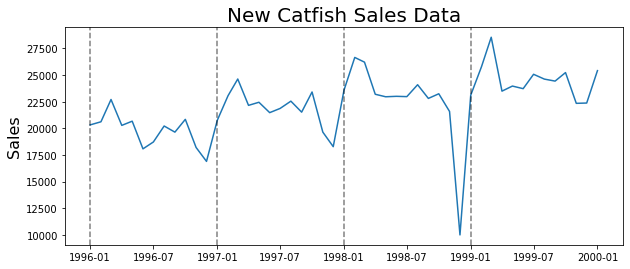

In [25]:
#plotting the data with anomaly

plt.figure(figsize = (10,4))
plt.plot(catfish_sales)

plt.title("New Catfish Sales Data", fontsize = 20)
plt.ylabel("Sales", fontsize = 16)

for year in range(start_date.year, end_date.year):
    plt.axvline(datetime(year,1,1), color = "k", linestyle = "--", alpha = 0.5)

# Remove the trend

In [26]:
first_diff = catfish_sales.diff().dropna()

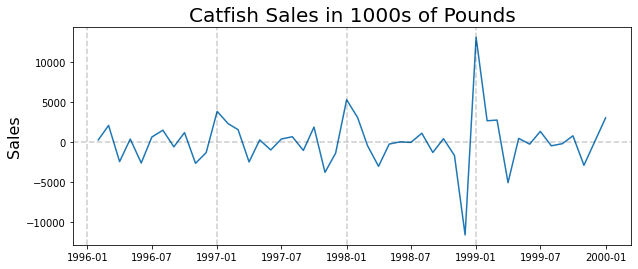

In [27]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Get Training and Test data

In [28]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = catfish_sales[train_end+ timedelta(days = 1):test_end]

In [30]:
test_data.index

DatetimeIndex(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01',
               '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

# Prediction

In [29]:
my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)


In [31]:
rolling_predictions = test_data.copy()

for train_end in test_data.index:
    train_data = catfish_sales[:train_end - timedelta(days = 1)]
    model = SARIMAX(train_data,order = my_order, seasonal_order = my_seasonal_order)
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [32]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

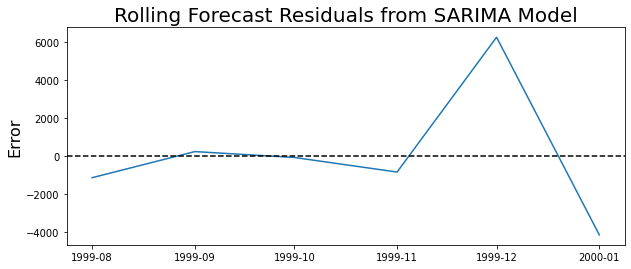

In [34]:
#plotting Residuals

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

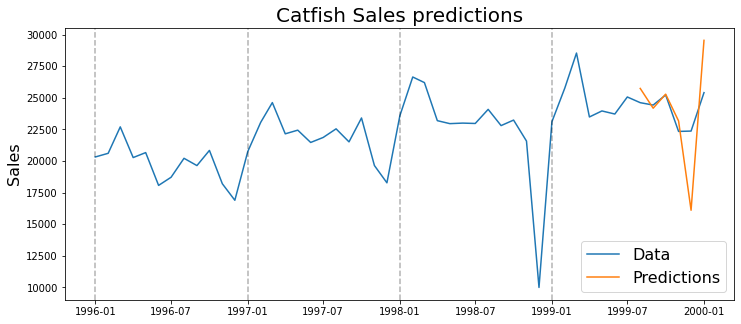

In [35]:
#plotting prediction result

plt.figure(figsize = (12,5))
plt.plot(catfish_sales)
plt.plot(rolling_predictions)

plt.title("Catfish Sales predictions", fontsize = 20)
plt.ylabel("Sales", fontsize = 16)
plt.legend(("Data", "Predictions"), fontsize = 16)

for year in range(start_date.year, end_date.year):
    plt.axvline(datetime(year,1,1),color = "k", linestyle = "--", alpha = 0.3)

In [37]:
# MAPE 

print("Mean Absolute Percent Error: ", round(np.mean(abs(rolling_predictions/test_data)),4))

Mean Absolute Percent Error:  0.993


In [38]:
# RMSE

print("Root Mean Squared Error: ", np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error:  3119.1661011665706


# Detecting Anomaly

In [51]:
# Attempt 1 : Deviation Method

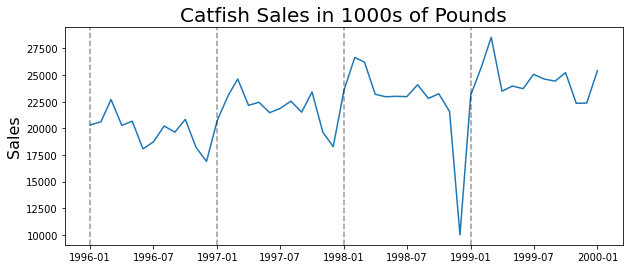

In [42]:
plt.figure(figsize=(10,4))
plt.plot(catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.4)

In [43]:
rolling_deviation = pd.Series(dtype = float, index = catfish_sales.index)

In [44]:
rolling_deviation.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01', '1997-11-01', '1997-12-01',
               '1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01',
               '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01',
               '1998-09-01', '1998-10-01', '1998-11-01', '1998-12-01',
               '1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01', '1999-11-01', '1999-12-01',
               '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

In [47]:
for date in rolling_deviation.index:
    
    #get the window ending at this data point
    window = catfish_sales.loc[:date]
    
    #get the deviation within this window
    rolling_deviation.loc[date] = window.std()

In [48]:
#get the deviation difference betwwen one time point and next time point

diff_roll_dev = rolling_deviation.diff()
diff_roll_dev = diff_roll_dev.dropna()

In [49]:
diff_roll_dev

Date
1996-03-01    1093.647565
1996-04-01    -139.611236
1996-05-01    -145.877037
1996-06-01     458.946561
1996-07-01      21.246074
1996-08-01    -110.815080
1996-09-01     -76.077319
1996-10-01     -54.778817
1996-11-01      80.512076
1996-12-01     226.024241
1997-01-01     -41.775128
1997-02-01     175.221115
1997-03-01     318.078650
1997-04-01     -17.841314
1997-05-01      -5.641973
1997-06-01     -48.435398
1997-07-01     -34.033987
1997-08-01      -5.919398
1997-09-01     -41.537143
1997-10-01      36.228047
1997-11-01     -23.461791
1997-12-01      35.514263
1998-01-01      41.376427
1998-02-01     269.009127
1998-03-01     167.204644
1998-04-01     -17.570402
1998-05-01     -24.106633
1998-06-01     -22.932892
1998-07-01     -23.339043
1998-08-01       7.472783
1998-09-01     -26.770379
1998-10-01     -18.162812
1998-11-01     -33.363392
1998-12-01     708.888216
1999-01-01     -26.914961
1999-02-01      46.648799
1999-03-01     169.912338
1999-04-01     -27.487091
1999-05

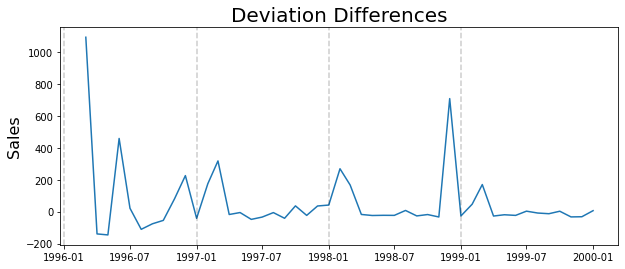

In [50]:
plt.figure(figsize=(10,4))
plt.plot(diff_roll_dev)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Attempt 2 : Seasonal Method

In [53]:
month_deviation = catfish_sales.groupby(lambda d :d.month).std()

In [54]:
month_deviation

Date
1     2105.840402
2     2741.500973
3     2473.136790
4     1452.396726
5     1379.643764
6     2510.305343
7     2648.906992
8     1973.452305
9     2025.372949
10    1800.032407
11    1876.056947
12    5146.228263
Name: Total, dtype: float64

Text(0, 0.5, 'Sales')

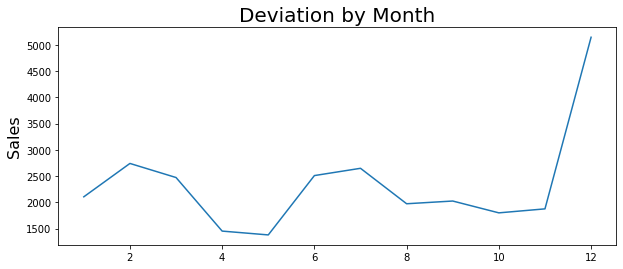

In [56]:
plt.figure(figsize=(10,4))
plt.plot(month_deviation)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

**From the plot we can say that anomaly occurs in month December**

In [59]:
december_data = catfish_sales[catfish_sales.index.month == 12]

In [60]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [61]:
min_dev  = 9999999
curr_anomaly = None

for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [62]:
curr_anomaly 

Timestamp('1998-12-01 00:00:00')

# What to do about anomaly?

# Simple Idea: Use mean of other months

In [86]:
adjusted_data = catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

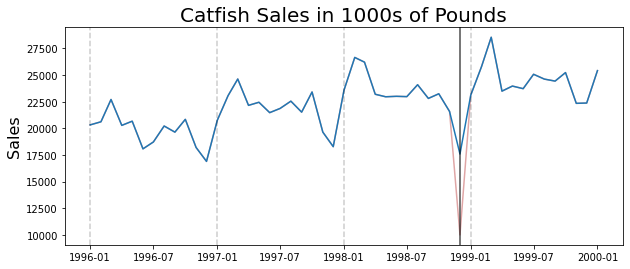

In [87]:
plt.figure(figsize=(10,4))
plt.plot(catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [88]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]


In [89]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

At iterate   30    f=  8.52885D+00    |proj g|=  1.62811D-03

At iterate   35    f=  8.52878D+00    |proj g|=  4.10245D-03

At iterate   40    f=  8.52873D+00    |proj g|=  1.88617D-03

At iterate   45    f=  8.52868D+00    |proj g|=  2.52456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46     65      1     0     0   2.564D-04   8.529D+00
  F =   8.5286796705042125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

In [90]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

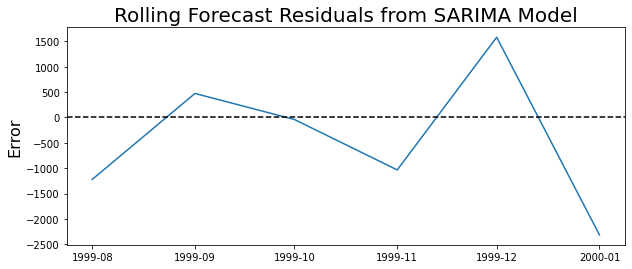

In [91]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

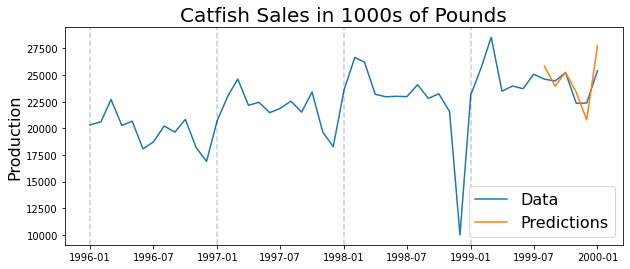

In [92]:
plt.figure(figsize=(10,4))

plt.plot(catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [93]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0464


In [94]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1331.0164036054052
